In [53]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

In [ ]:
roi_df = pd.read_csv("./inputs/roi_data.csv", index_col=0)
roi_df.head()

In [ ]:
roi_df.describe()

In [89]:
ROIs = [
    "Thalamus",
    "Caudate",
    "Putamen",
    "Pallidum",
    "Hippocampus",
    "Amygdala",
    "Accumbens-area",
]

target_columns = ["thickness_change"] + [region+"_change_pred" for region in ROIs]

In [57]:
#get specific columns of the dataframe
target_df = roi_df.loc[:, target_columns]
PD_MCI_df = target_df.loc[roi_df["dx_group"] == "PD-MCI"]
PD_non_MCI_df = target_df.loc[roi_df["dx_group"] == "PD-non-MCI"]
HC_df = target_df.loc[roi_df["dx_group"] == "HC"]


In [172]:
# for region in target_columns:
#     t, p = ttest_ind(PD_MCI_df[region], PD_non_MCI_df[region])
#     print("PD_MCI vs PD-non-MCI", region, "t:", t, "p:", p)
#     t, p = ttest_ind(PD_MCI_df[region], HC_df[region])
#     print("PD_MCI vs HC", region, "t:", t, "p:", p)
#     t, p = ttest_ind(HC_df[region], PD_non_MCI_df[region])
#     print("HC vs PD-non-MCI", region, "t:", t, "p:", p)
    
    

- Don't they need multiple comparison correction?
- Numbers are close but not the same. (this was because I used `pred_pct` columns instead of `pred`)

In [59]:
roi_df["dx_group"].value_counts()

HC            18
PD-non-MCI    15
PD-MCI        10
Name: dx_group, dtype: int64

In [60]:
n_regions = len(target_columns)

MCIvsHC_stats = np.zeros((n_regions, 1000, 2))
MCIvsnonMCI_stats = np.zeros((n_regions, 1000, 2))
nonMCIvsHC_stats = np.zeros((n_regions, 1000, 2))

PD_MCI_index = PD_MCI_df.index.tolist()
PD_non_MCI_index = PD_non_MCI_df.index.tolist()
HC_index = HC_df.index.tolist()

n_PD_MCI = len(PD_MCI_index)
n_PD_non_MCI = len(PD_non_MCI_index)
n_HC = len(HC_index)

In [61]:
n_regions

8

In [62]:
for itr in range(1000):

    MCI_sample = list(np.random.choice(PD_MCI_index, n_PD_MCI, replace=True))
    nonMCI_sample = list(np.random.choice(PD_non_MCI_index, n_PD_non_MCI, replace=True))
    HC_sample = list(np.random.choice(HC_index, n_HC, replace=True))

    for i in range(n_regions):
        region = target_columns[i]
        MCIvsnonMCI_stats[i][itr] = ttest_ind(PD_MCI_df[region].loc[MCI_sample], PD_non_MCI_df[region].loc[nonMCI_sample])
        nonMCIvsHC_stats[i][itr] = ttest_ind(HC_df[region].loc[HC_sample], PD_non_MCI_df[region].loc[nonMCI_sample])
        MCIvsHC_stats[i][itr] = ttest_ind(PD_MCI_df[region].loc[MCI_sample], HC_df[region].loc[HC_sample])


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

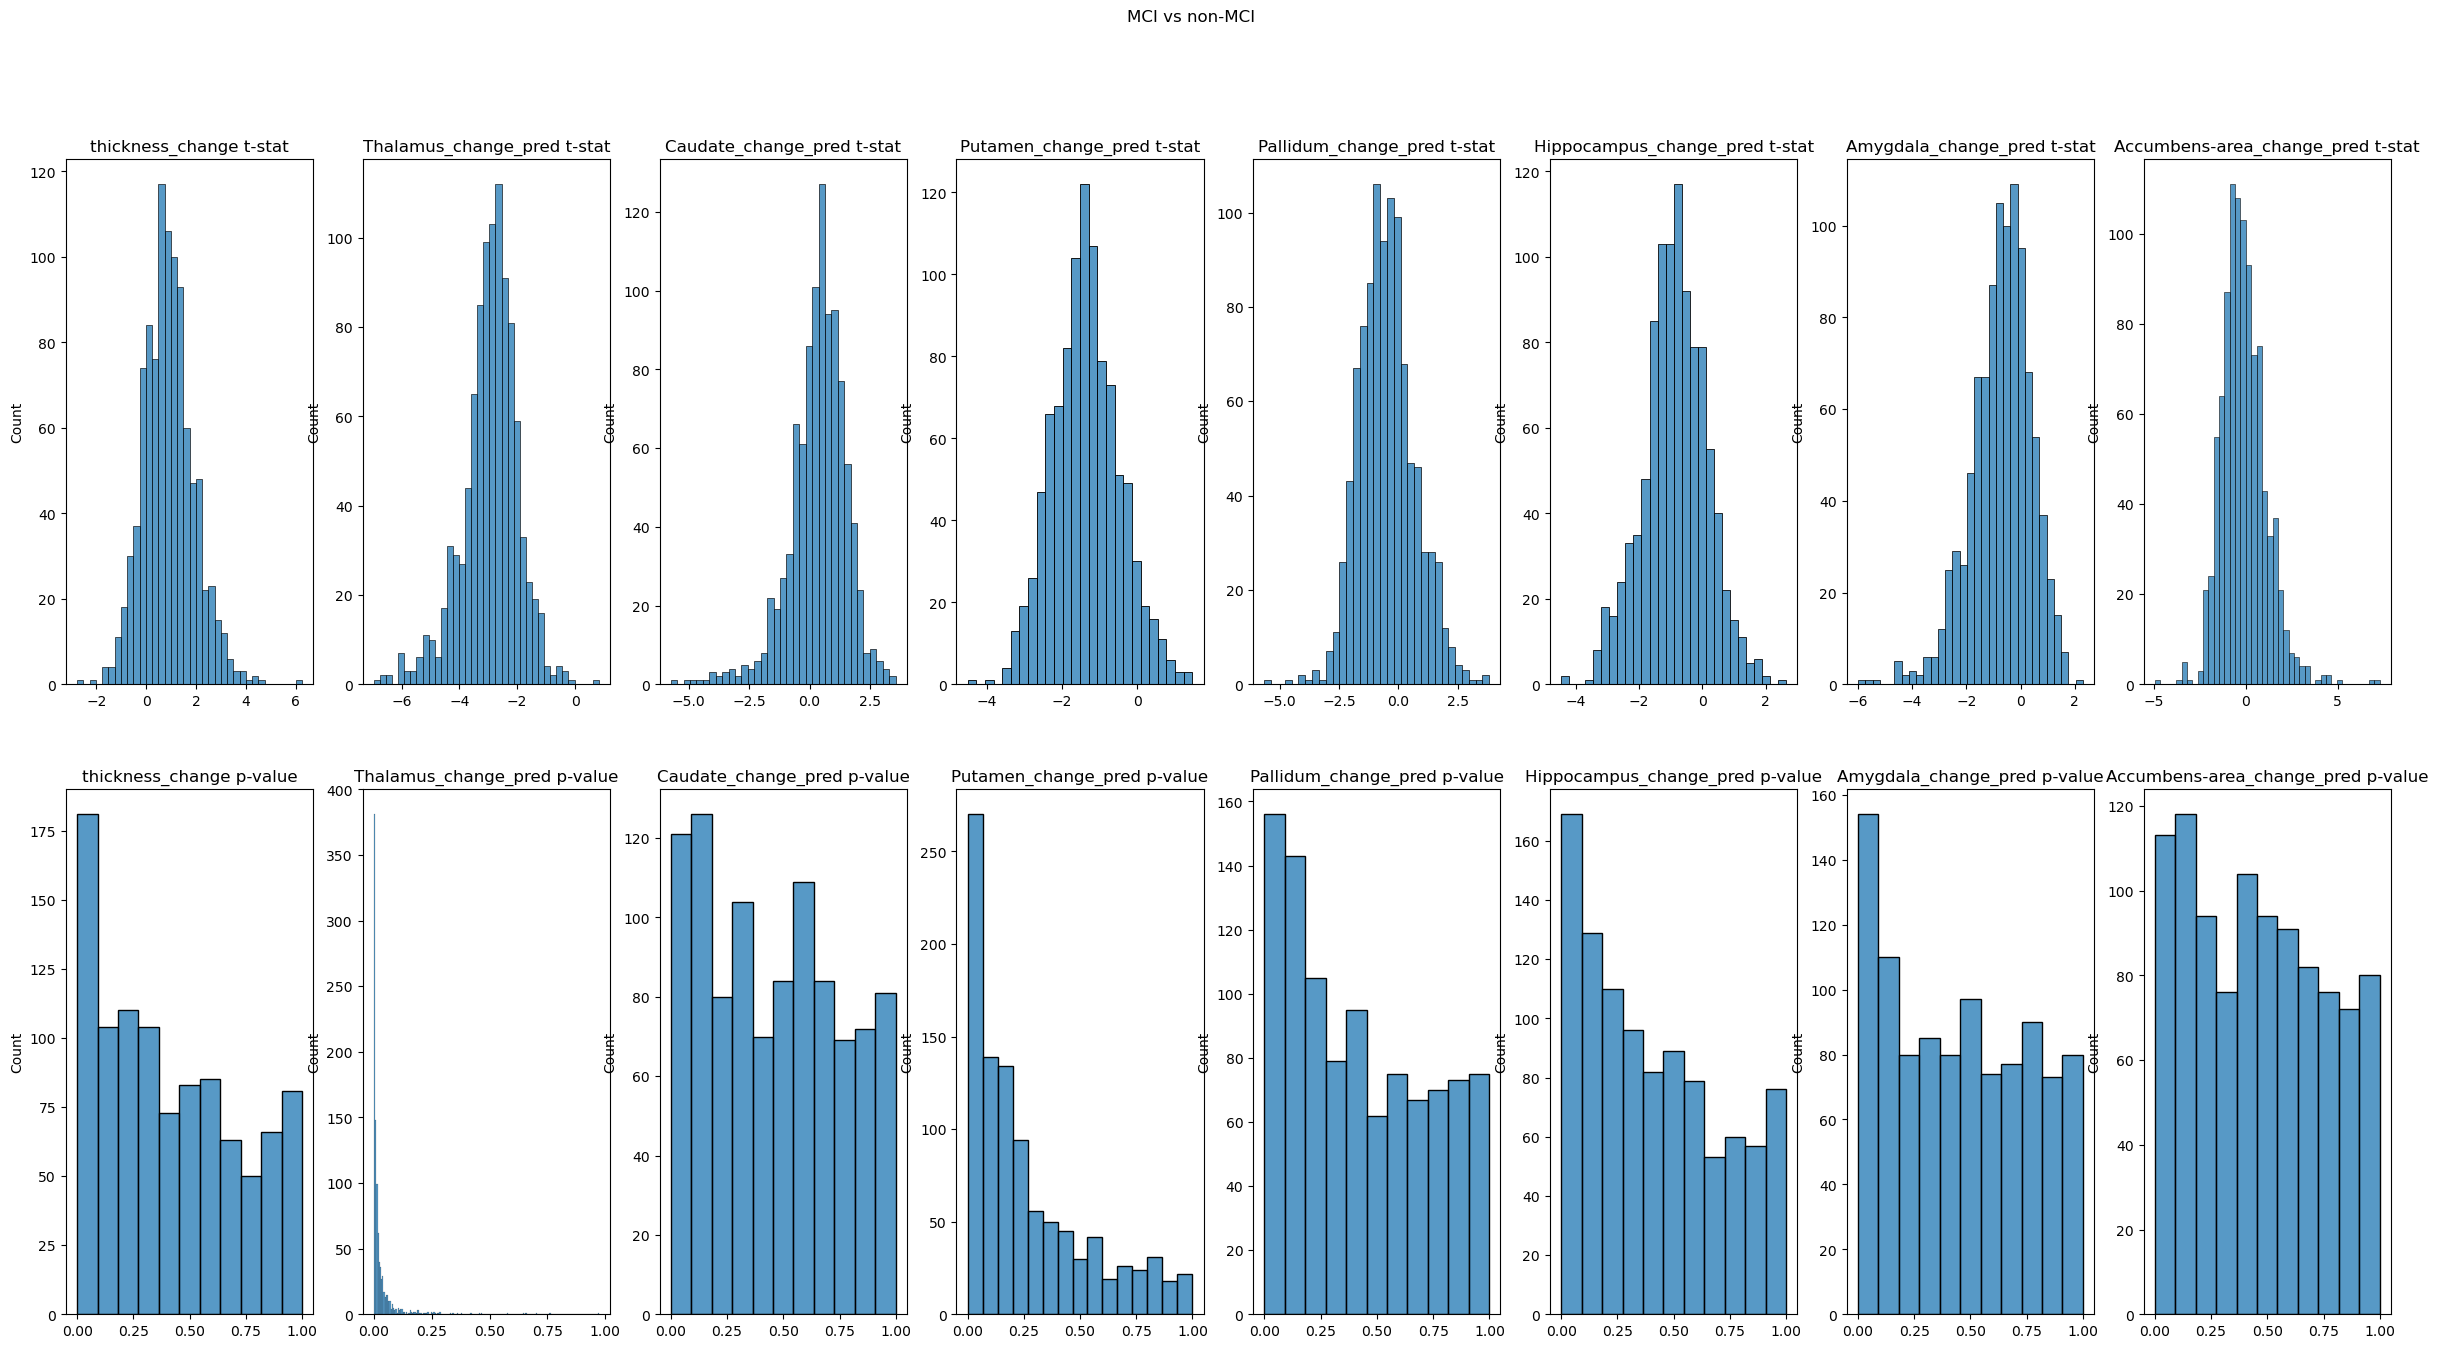

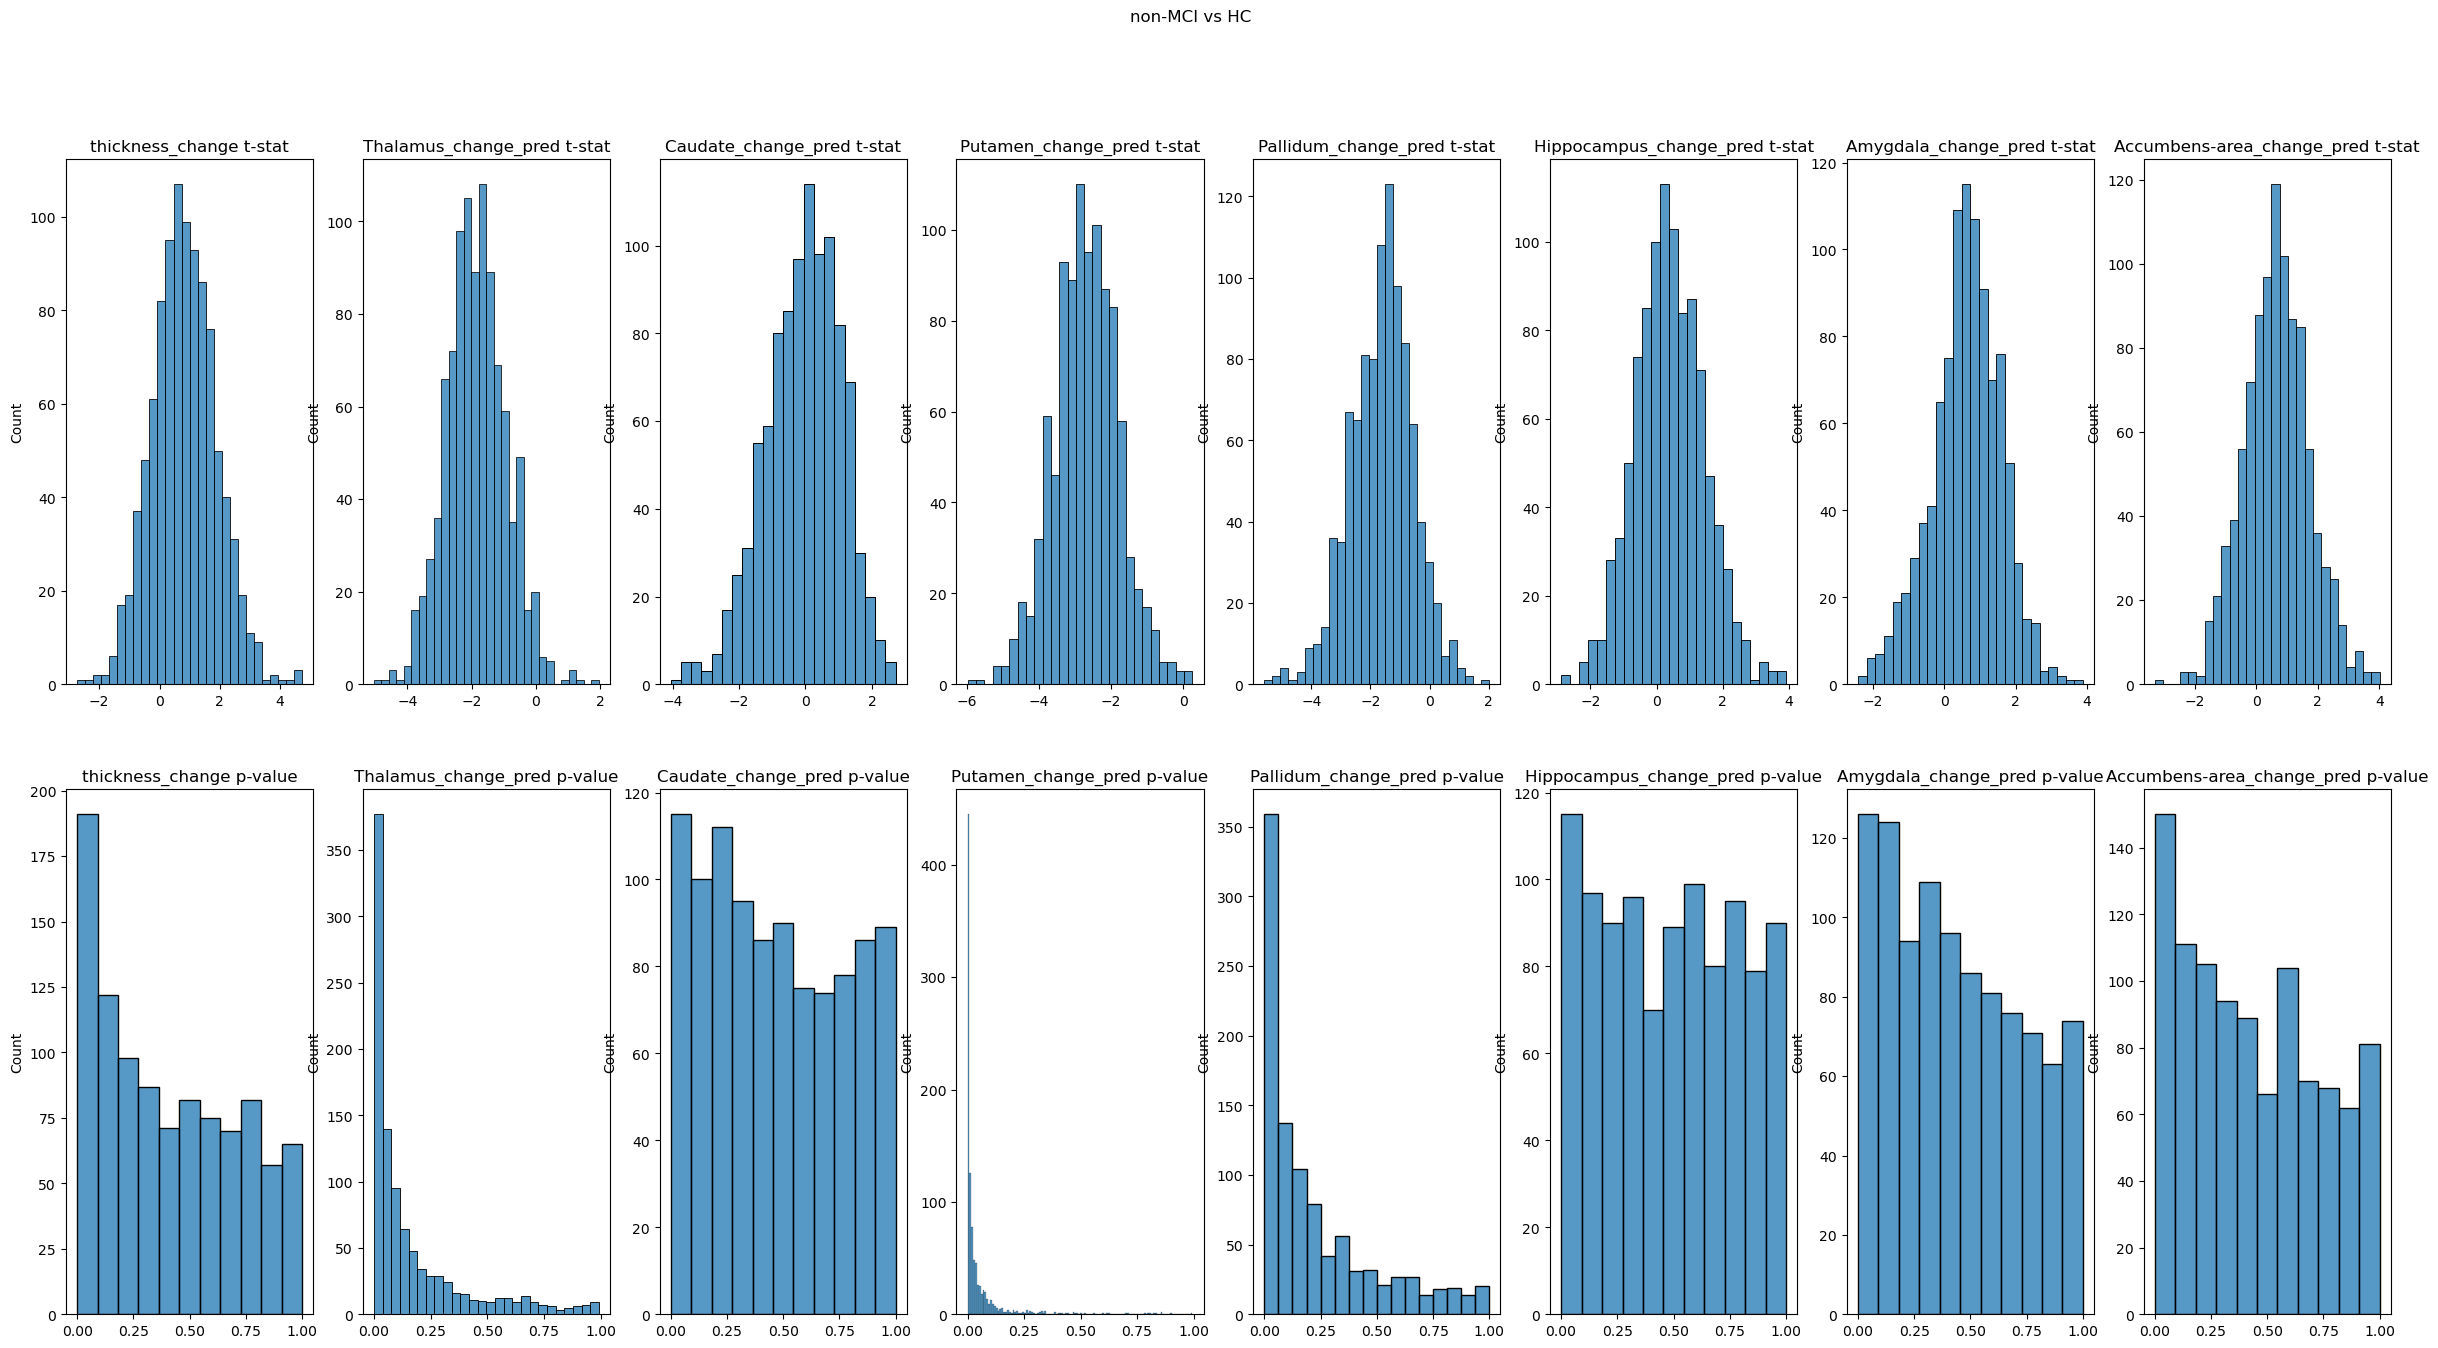

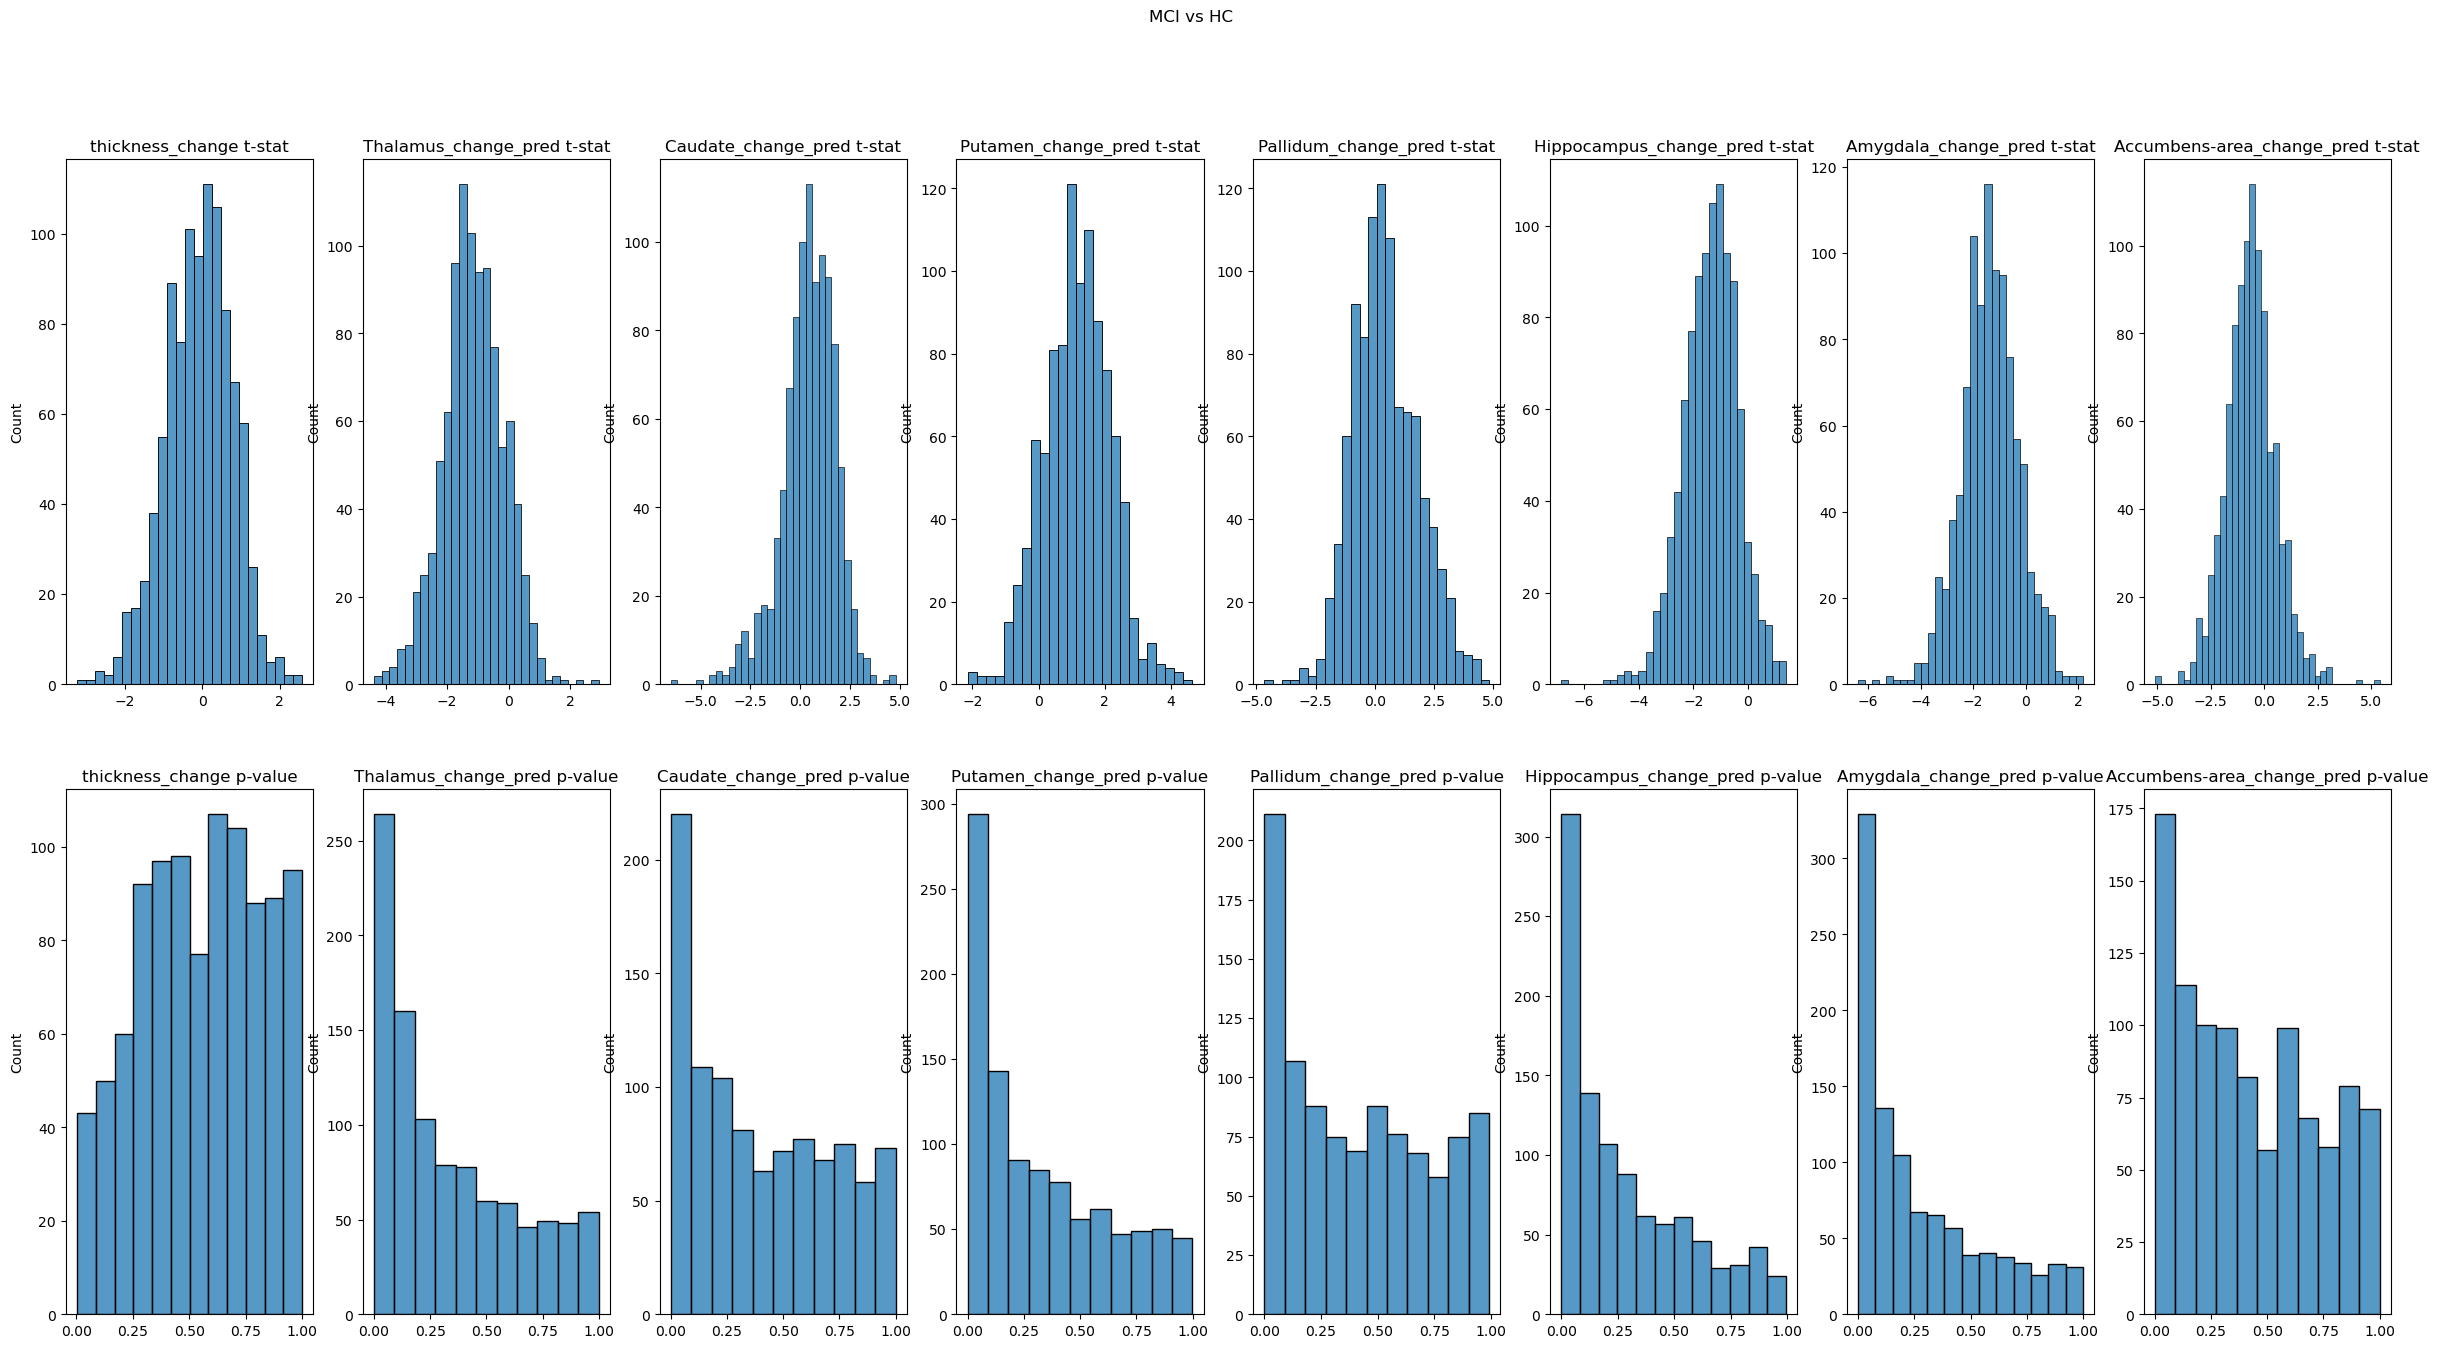

In [68]:
titles = ["MCI vs non-MCI", "non-MCI vs HC", "MCI vs HC"]
stats = [MCIvsnonMCI_stats, nonMCIvsHC_stats, MCIvsHC_stats]

for i in range(3):
    f, ax = plt.subplots(nrows=2, ncols=n_regions, figsize=(30, 15))
    f.suptitle(titles[i])
    for j in range(n_regions):
        ax[0,j].set_title(target_columns[j] + " t-stat")
        ax[0,j] = sns.histplot(stats[i][j, :, 0], ax=ax[0,j])
        ax[1,j].set_title(target_columns[j] + " p-value")
        ax[1,j] = sns.histplot(stats[i][j, :, 1], ax=ax[1,j])

In [173]:
# for j in range(n_regions):    
#     for i in range(3):
#         print(titles[i], target_columns[j], "t-stat:", np.mean(stats[i][j, :, 0]), "p-value:", np.mean(stats[i][j, :, 1]))

In [76]:
data = {titles[i]: stats[i][:,:,1].mean(axis=1) for i in range(3)}
df = pd.DataFrame(data)
df.index = target_columns

In [82]:
df

,MCI vs non-MCI,non-MCI vs HC,MCI vs HC
thickness_change,0.418101,0.410637,0.553218
Thalamus_change_pred,0.033268,0.167309,0.339995
Caudate_change_pred,0.456965,0.468808,0.403984
Putamen_change_pred,0.270441,0.050898,0.331038
Pallidum_change_pred,0.423580,0.228513,0.416886
Hippocampus_change_pred,0.408128,0.482002,0.289015
Amygdala_change_pred,0.452675,0.439381,0.281623
Accumbens-area_change_pred,0.462331,0.434935,0.422947


In [85]:
data = {titles[i]: np.median(stats[i][:,:,1],axis=1) for i in range(3)}
df = pd.DataFrame(data)
df.index = target_columns

In [86]:
df

,MCI vs non-MCI,non-MCI vs HC,MCI vs HC
thickness_change,0.371569,0.370026,0.569240
Thalamus_change_pred,0.008749,0.070142,0.250043
Caudate_change_pred,0.452074,0.446802,0.343686
Putamen_change_pred,0.169763,0.011132,0.244202
Pallidum_change_pred,0.380296,0.128299,0.380489
Hippocampus_change_pred,0.358848,0.485554,0.202199
Amygdala_change_pred,0.448014,0.409503,0.178290
Accumbens-area_change_pred,0.447513,0.402645,0.383744


In [92]:
target_columns.pop(0)

'thickness_change'

In [95]:
target_correlation = ["MCATOT_diff"]
for side in ["Left-", "Right-"]:
    for region in target_columns:
        target_correlation.append(side+region)

In [96]:
target_correlation

['MCATOT_diff',
 'Left-Thalamus_change_pred',
 'Left-Caudate_change_pred',
 'Left-Putamen_change_pred',
 'Left-Pallidum_change_pred',
 'Left-Hippocampus_change_pred',
 'Left-Amygdala_change_pred',
 'Left-Accumbens-area_change_pred',
 'Right-Thalamus_change_pred',
 'Right-Caudate_change_pred',
 'Right-Putamen_change_pred',
 'Right-Pallidum_change_pred',
 'Right-Hippocampus_change_pred',
 'Right-Amygdala_change_pred',
 'Right-Accumbens-area_change_pred']

In [123]:
n_target_correlation = len(target_correlation)
target_corr_df = roi_df.loc[PD_MCI_index + PD_non_MCI_index][target_correlation]

In [ ]:
target_corr_df

In [168]:
MCI_corr = np.zeros((n_target_correlation-1, 1000, 2))
non_MCI_corr = np.zeros((n_target_correlation-1, 1000, 2))
PD_corr = np.zeros((n_target_correlation-1, 1000, 2))

In [108]:
from scipy.stats import pearsonr

In [169]:
for itr in range(1000):
    MCI_sample = list(np.random.choice(PD_MCI_index, n_PD_MCI, replace=True))
    non_MCI_sample = list(np.random.choice(PD_non_MCI_index, n_PD_non_MCI, replace=True))
    PD_sample = list(np.random.choice(PD_MCI_index+PD_non_MCI_index, n_PD_MCI+n_PD_non_MCI, replace=True))

    for i in range(1,n_target_correlation):
        region = target_correlation[i]
        MCI_corr[i-1][itr] = pearsonr(target_corr_df[region].loc[MCI_sample], target_corr_df["MCATOT_diff"].loc[MCI_sample])
        non_MCI_corr[i-1][itr] = pearsonr(target_corr_df[region].loc[non_MCI_sample], target_corr_df["MCATOT_diff"].loc[non_MCI_sample])
        PD_corr[i-1][itr] = pearsonr(target_corr_df[region].loc[PD_sample], target_corr_df["MCATOT_diff"].loc[PD_sample])

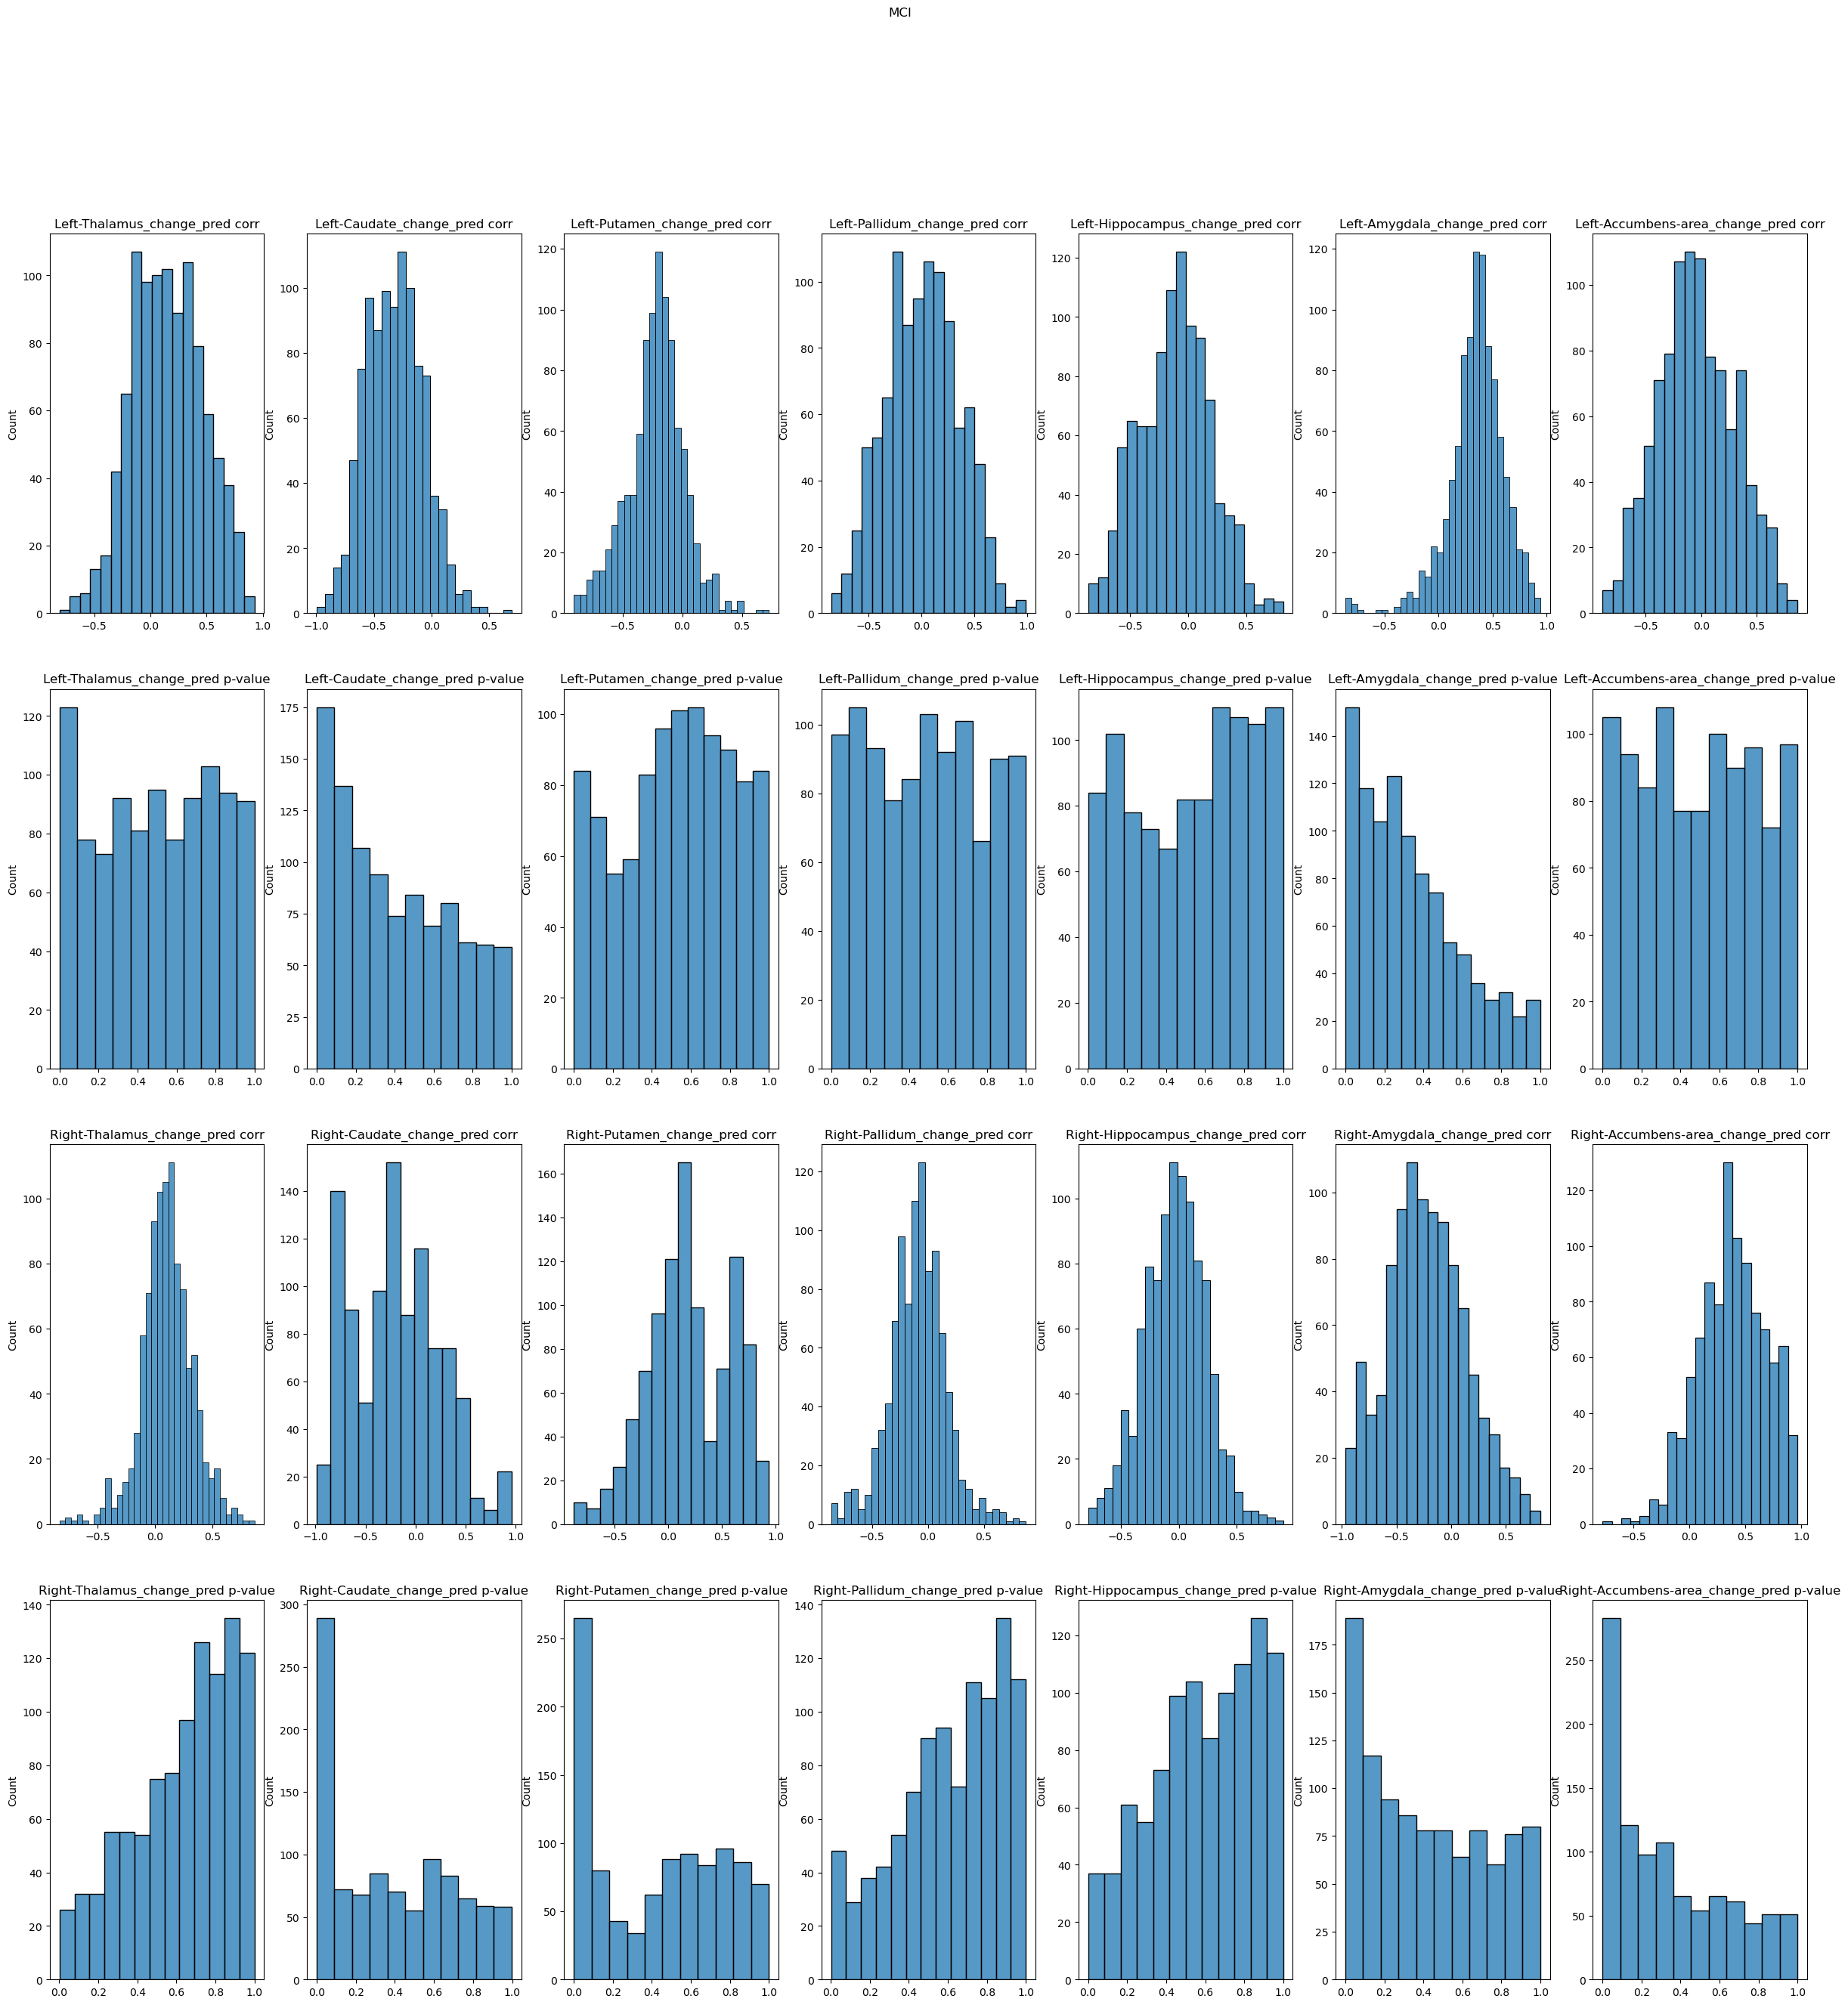

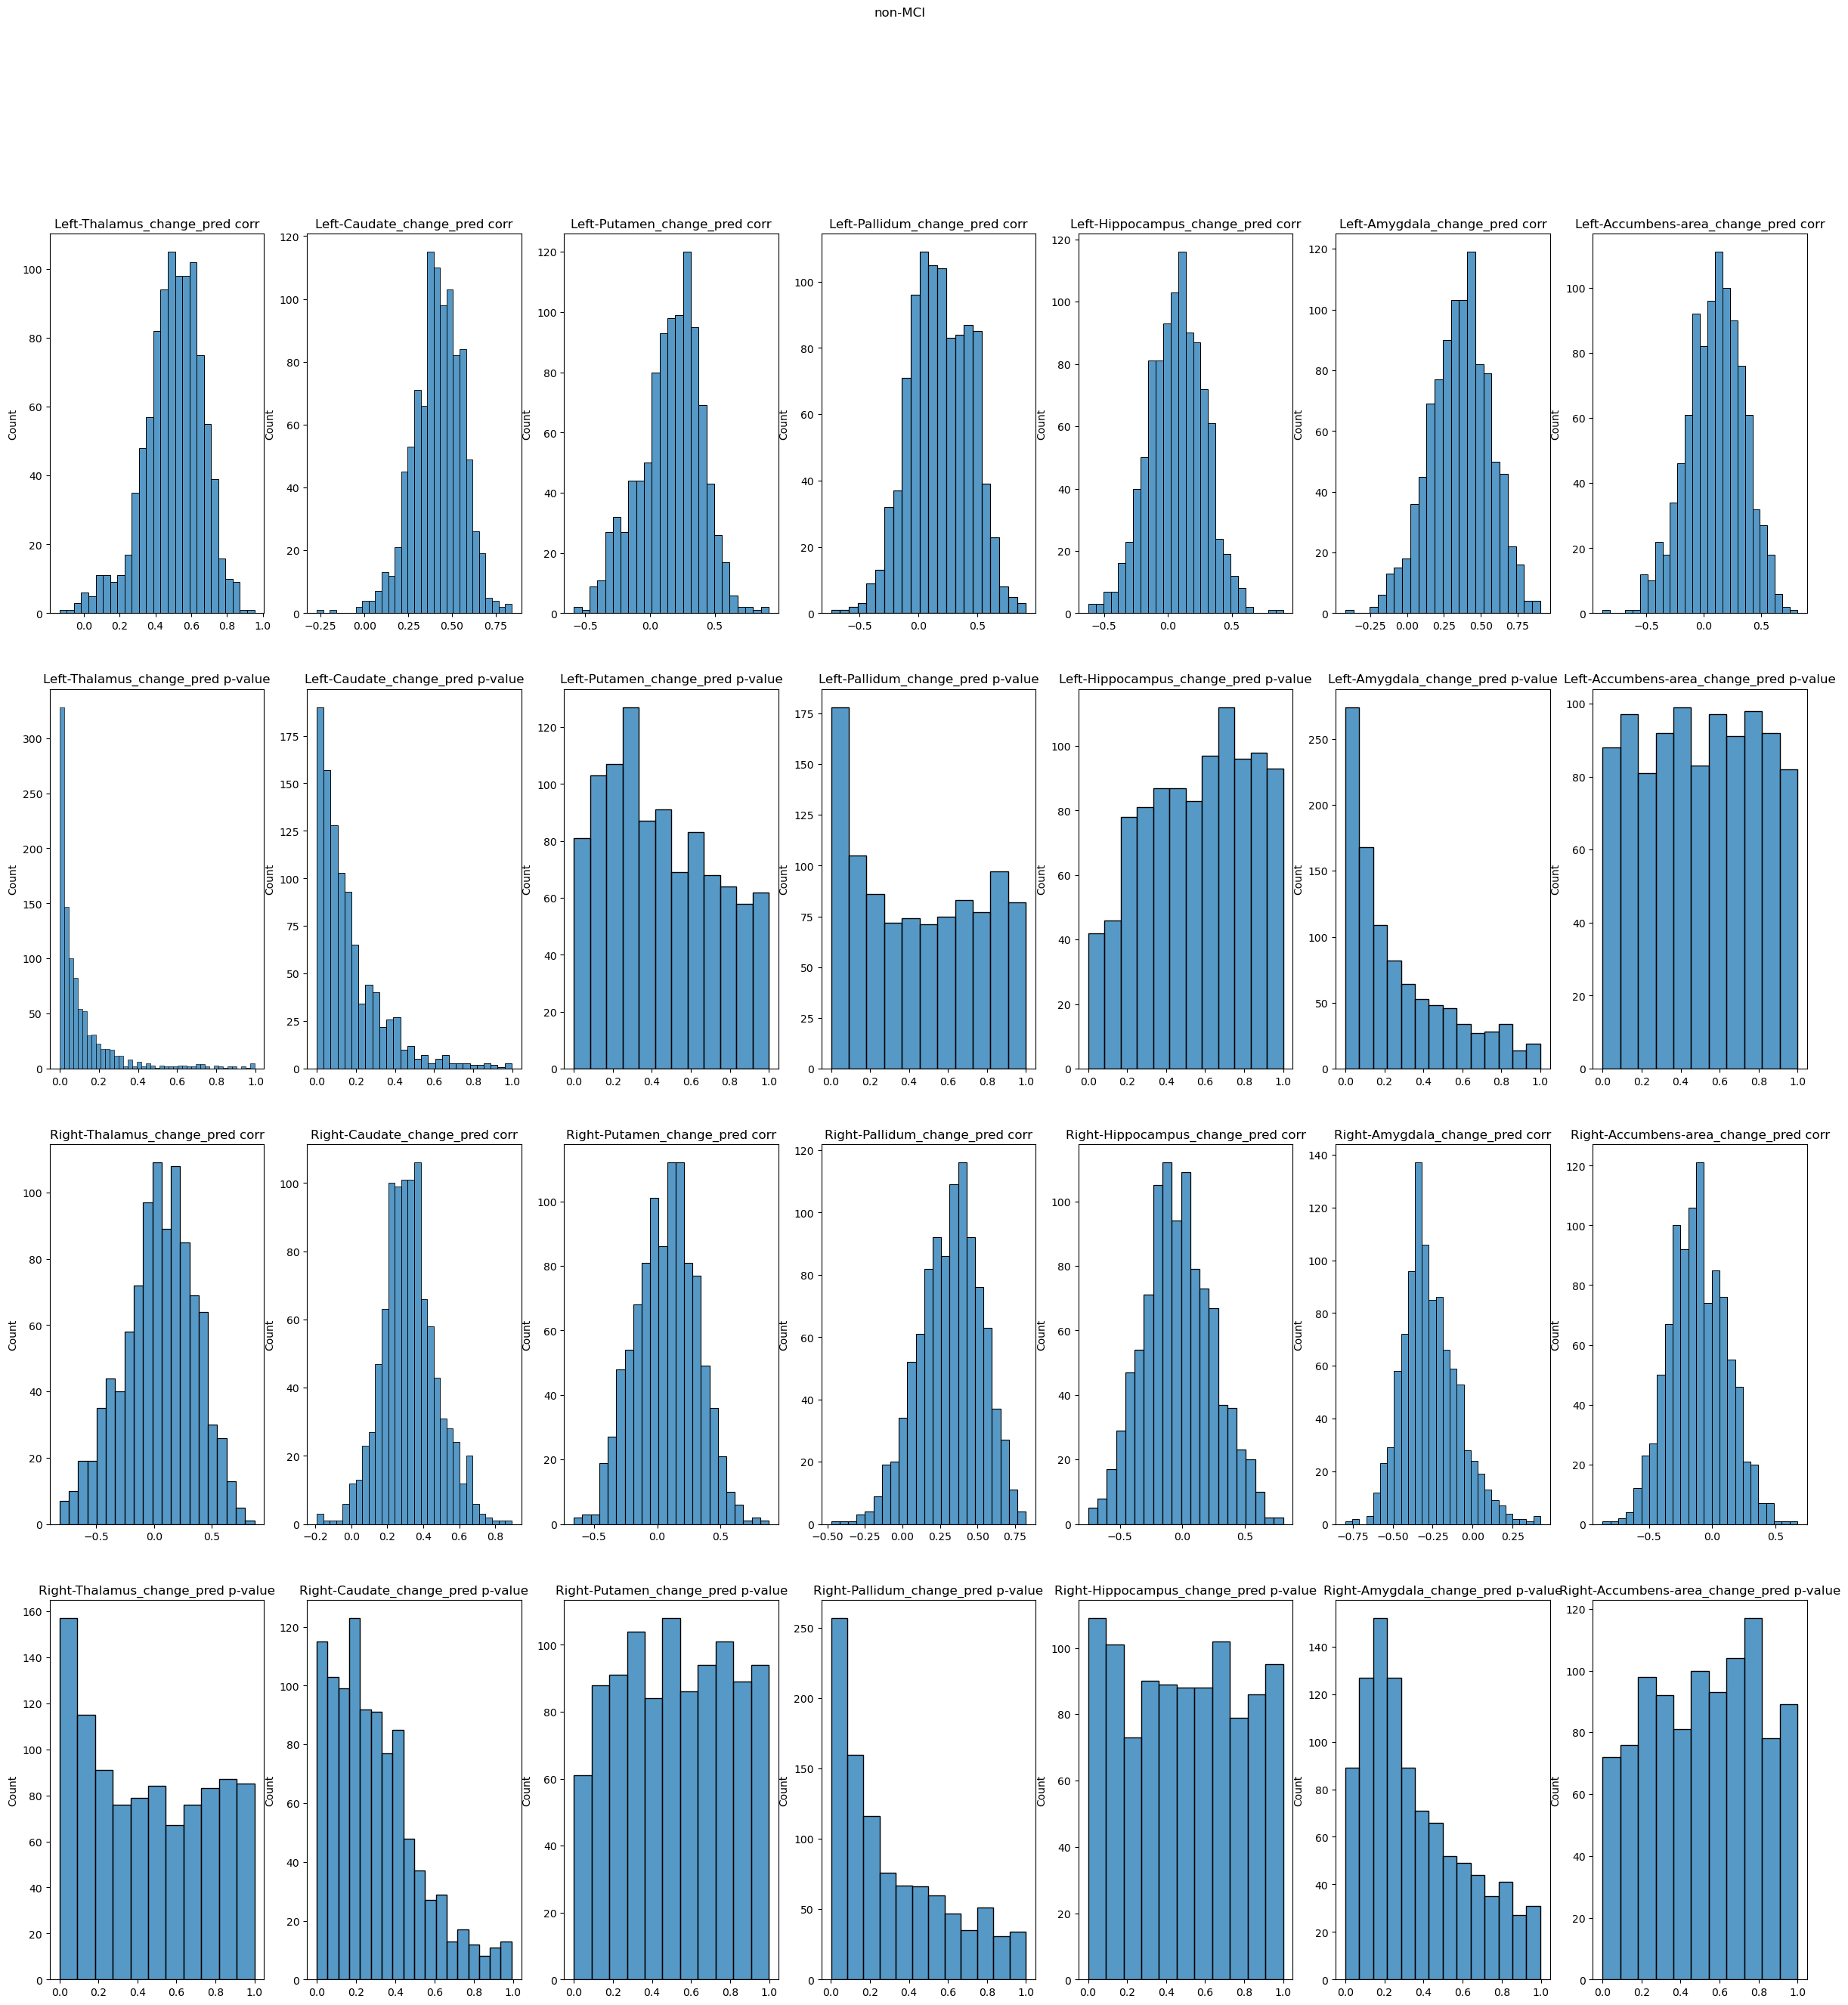

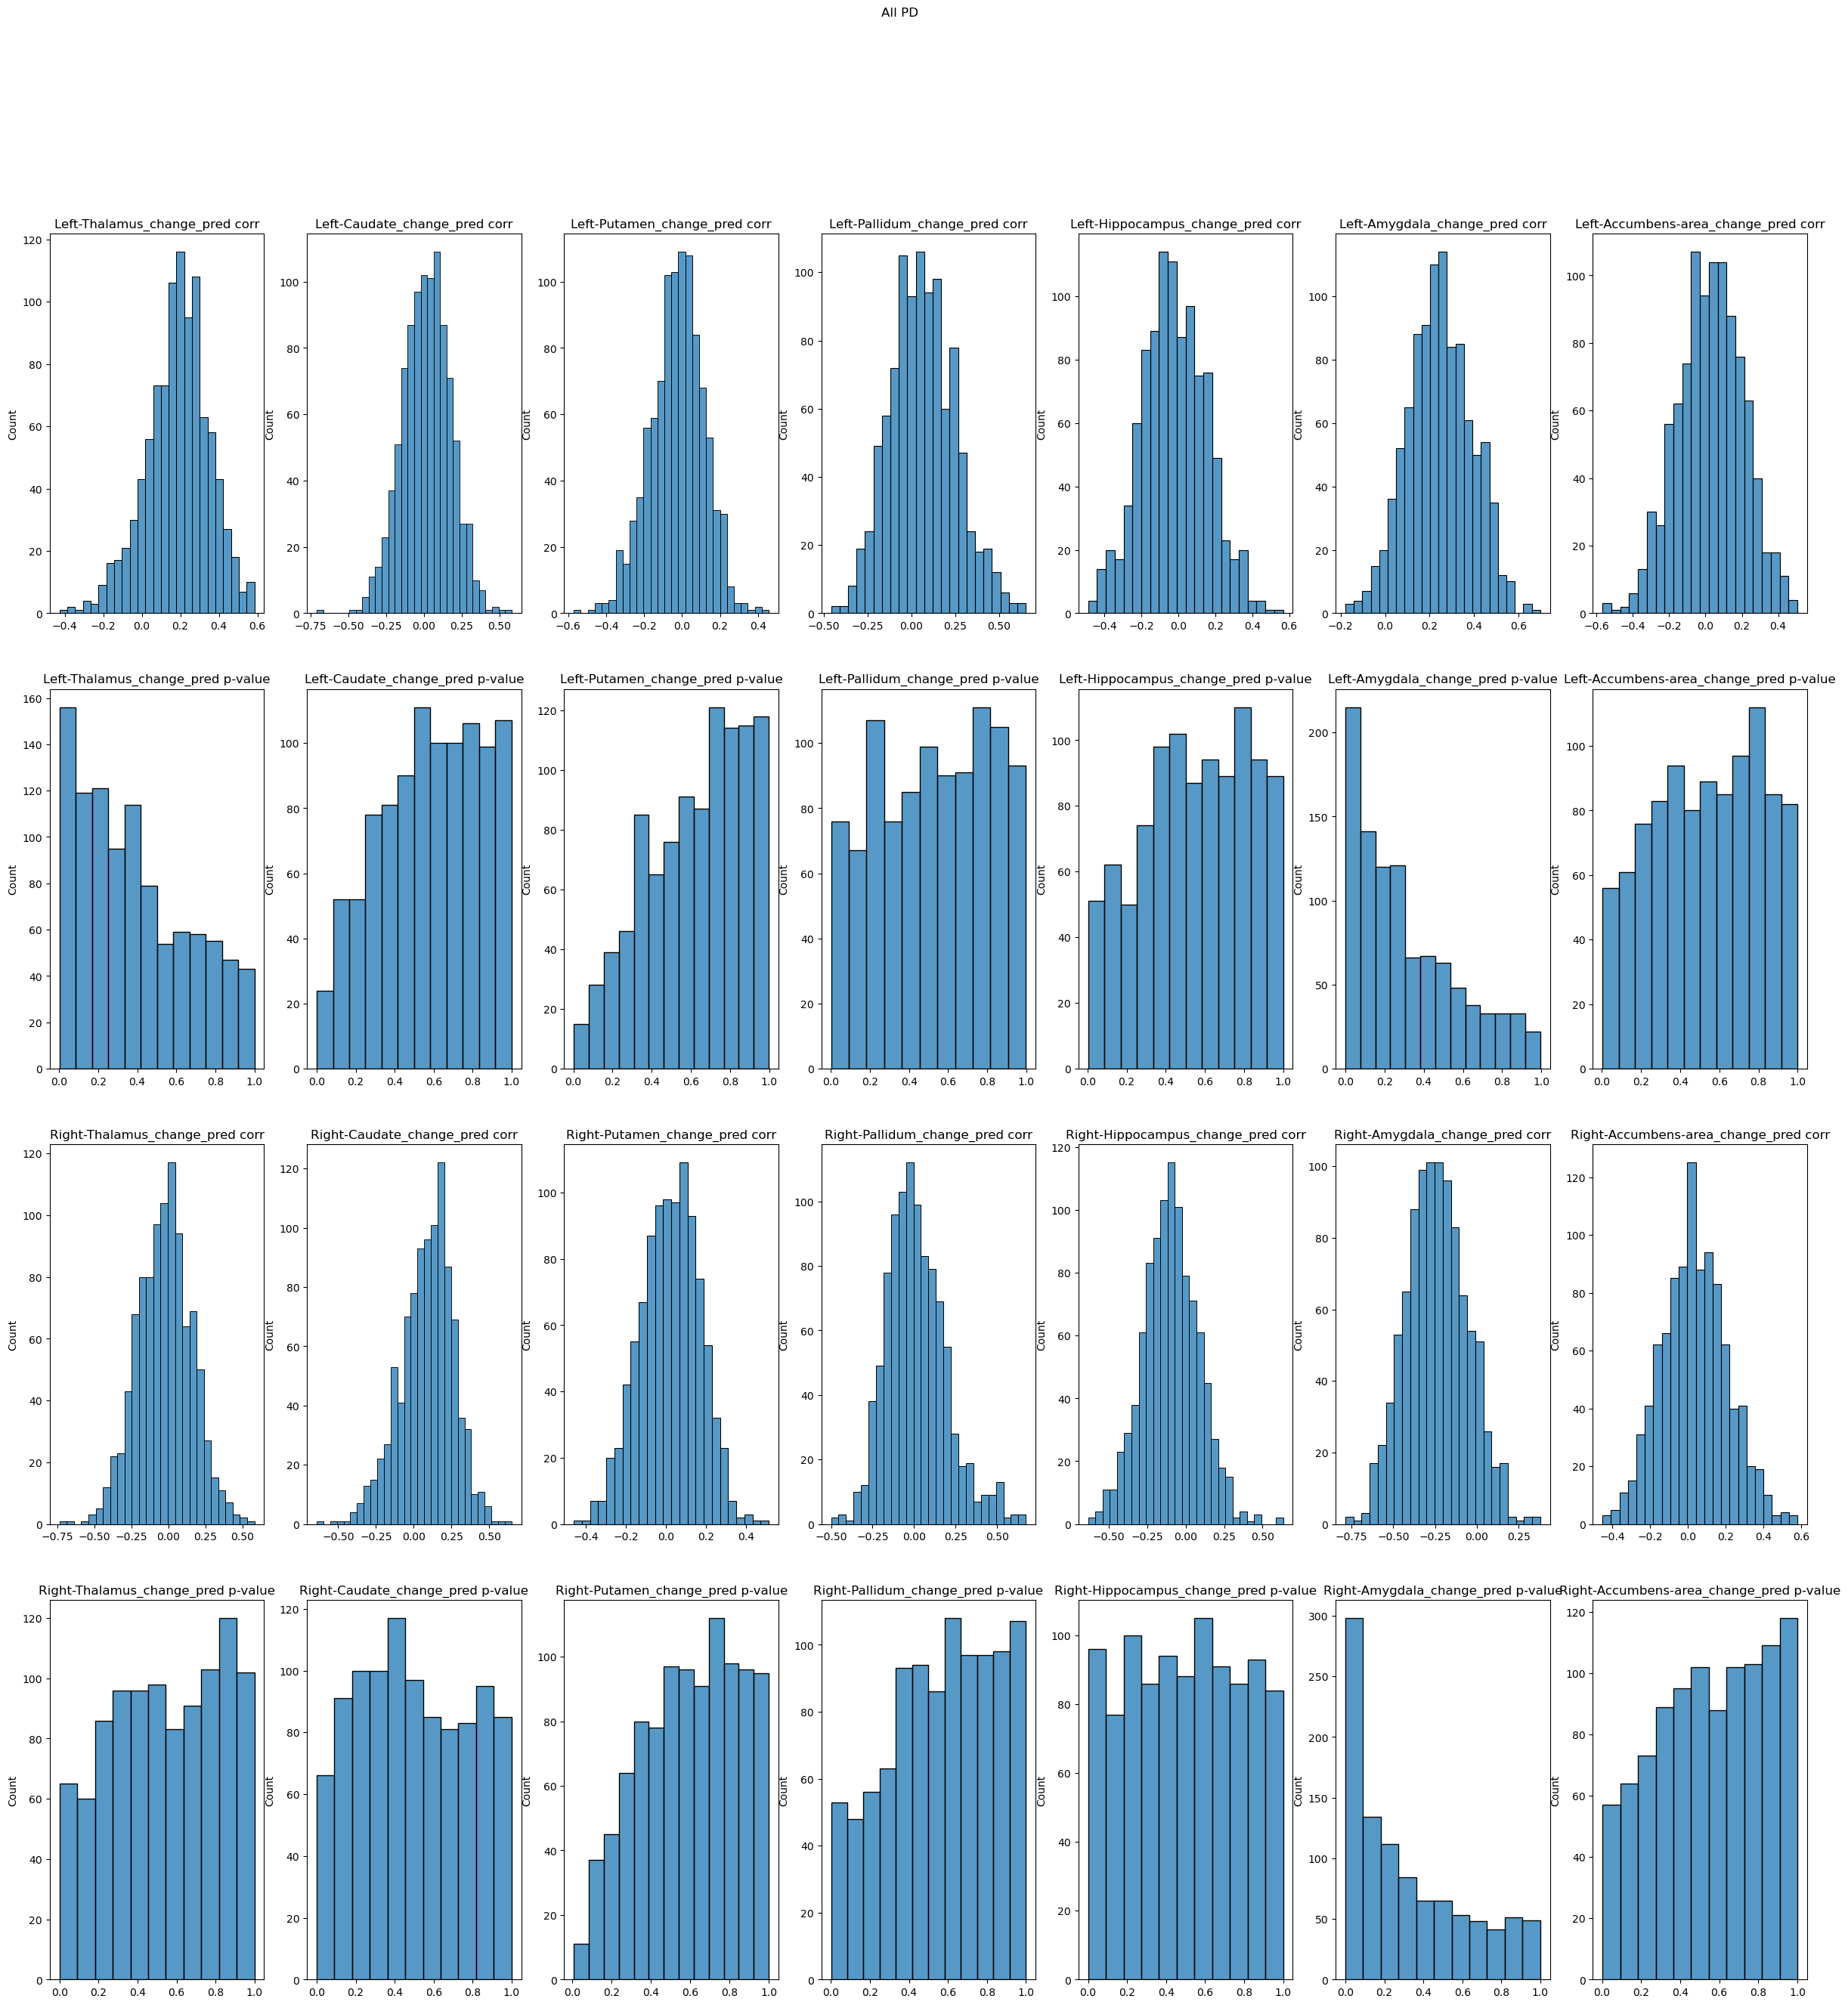

In [171]:
corr_result = [MCI_corr, non_MCI_corr, PD_corr]
corr_title = ["MCI", "non-MCI", "All PD"]
for cohort_idx in range(3):
    f, ax = plt.subplots(nrows=4, ncols=7, figsize=(30, 30))
    f.suptitle(corr_title[cohort_idx])
    for j in range(int((n_target_correlation-1)/2)):
        for i,k in zip(range(0,3,2), range(0,8,7)):
            ax[i,j].set_title(target_correlation[j+1+k]+ " corr")
            ax[i,j] = sns.histplot(corr_result[cohort_idx][j+k, :, 0], ax=ax[i,j])
            ax[i+1,j].set_title(target_correlation[j+1+k] + " p-value")
            ax[i+1,j] = sns.histplot(corr_result[cohort_idx][j+k, :, 1], ax=ax[i+1,j])
